In [ ]:
import numpy as np
import pandas as pd
import pathlib
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='/content/drive/MyDrive/skin disease'
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('/content/drive/MyDrive/skin disease')

In [ ]:
Acne= list(data_dir.glob('Acne/*'))
Eczema= list(data_dir.glob('Eczema/*'))
Psoriasis= list(data_dir.glob('Psoriasis_and_LP/*'))
Ringworm= list(data_dir.glob('Ringworm/*'))

In [ ]:
# Contains the images path
df_images = {
'Acne':Acne,
'Eczema':Eczema,
'Psoriasis':Psoriasis,
'Ringworm':Ringworm,
}

# Contains numerical labels for the categories
df_labels = {
'Acne':0,
'Eczema':1,
'Psoriasis':2,
'Ringworm':3,
}

In [ ]:
import cv2 as cv
X=[]
y=[]
for label, images in df_images.items():
    for image in images:
        img=cv.imread(str(image))
        img=cv.resize(img,(224,224))
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
        X.append(img)
        y.append(df_labels[label])

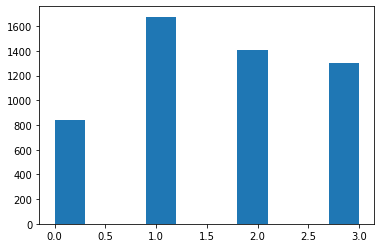

In [ ]:
import matplotlib.pyplot as plt
plt.hist(y)
plt.show()

In [ ]:
y = np.array(y)

In [ ]:
X = np.array(X)

In [ ]:
y.shape

(5222,)

In [ ]:
X.shape

(5222, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,random_state=42)

In [ ]:
X_train.shape

(3655, 224, 224, 3)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
res = VGG16(weights ='imagenet', include_top = False, input_shape = (224, 224, 3)) 

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
import keras
from keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras import Sequential, Model

res.trainable = False


x= res.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x) 
x = Dense(512, activation ='relu')(x)
x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

x = Dense(256, activation ='relu')(x)
x = BatchNormalization()(x)

x = Dense(4, activation ='softmax')(x)
model = Model(res.input, x)

model.compile(optimizer =tf.keras.optimizers.RMSprop(learning_rate=0.0001),  #'Adam'
              loss ="sparse_categorical_crossentropy",  #sparse_categorical_crossentropy
              metrics =["sparse_categorical_accuracy"])  #sparse_categorical_accuracy

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

In [ ]:
vgghist = model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
115/115 [==============================] - 40s 247ms/step - loss: 1.4562 - sparse_categorical_accuracy: 0.4057 - val_loss: 1.2260 - val_sparse_categorical_accuracy: 0.4907
Epoch 2/50
115/115 [==============================] - 25s 217ms/step - loss: 1.0928 - sparse_categorical_accuracy: 0.5535 - val_loss: 1.1340 - val_sparse_categorical_accuracy: 0.5463
Epoch 3/50
115/115 [==============================] - 28s 247ms/step - loss: 0.9160 - sparse_categorical_accuracy: 0.6317 - val_loss: 1.0884 - val_sparse_categorical_accuracy: 0.5648
Epoch 4/50
115/115 [==============================] - 28s 245ms/step - loss: 0.7736 - sparse_categorical_accuracy: 0.6952 - val_loss: 1.0478 - val_sparse_categorical_accuracy: 0.5916
Epoch 5/50
115/115 [==============================] - 25s 220ms/step - loss: 0.6906 - sparse_categorical_accuracy: 0.7313 - val_loss: 1.0152 - val_sparse_categorical_accuracy: 0.6018
Epoch 6/50
115/115 [==============================] - 25s 222ms/step - loss: 0.6021 -

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(X_test).argmax(axis=1)
accuracy_score(y_test,y_pred)

49/49 [==============================] - 7s 149ms/step


0.6662412252712189

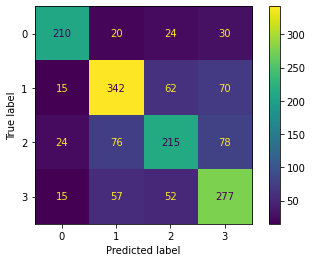

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()

In [ ]:
from keras.applications.inception_v3 import InceptionV3
base_model=InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3))

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for i in base_model.layers:
    i.trainable=False   

In [ ]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Flatten()(x)
x = Dense(128, activation ='relu')(x)
#x=Dropout(0.5)(x)
x = Dense(64, activation ='relu')(x)
pred=Dense(4,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=pred)

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 rmalization)                   )                                                           

In [ ]:
InceptionVRHist = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 100)

Epoch 1/100
115/115 [==============================] - 11s 100ms/step - loss: 1.0396 - accuracy: 0.5450 - val_loss: 1.3607 - val_accuracy: 0.4314
Epoch 2/100
115/115 [==============================] - 11s 99ms/step - loss: 0.9523 - accuracy: 0.5787 - val_loss: 1.3674 - val_accuracy: 0.4288
Epoch 3/100
115/115 [==============================] - 11s 100ms/step - loss: 0.9784 - accuracy: 0.5724 - val_loss: 1.2912 - val_accuracy: 0.4505
Epoch 4/100
115/115 [==============================] - 12s 102ms/step - loss: 0.9305 - accuracy: 0.5899 - val_loss: 1.3353 - val_accuracy: 0.4365
Epoch 5/100
115/115 [==============================] - 11s 100ms/step - loss: 0.9774 - accuracy: 0.5614 - val_loss: 1.3339 - val_accuracy: 0.4448
Epoch 6/100
115/115 [==============================] - 11s 100ms/step - loss: 0.9426 - accuracy: 0.5929 - val_loss: 1.4587 - val_accuracy: 0.4148
Epoch 7/100
115/115 [==============================] - 11s 99ms/step - loss: 0.9599 - accuracy: 0.5885 - val_loss: 1.3795 - v

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=model.predict(X_test).argmax(axis=1)
accuracy_score(y_test,y_pred)

49/49 [==============================] - 3s 66ms/step


0.44990427568602426

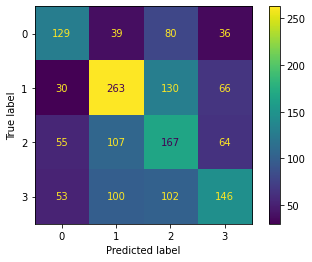

In [ ]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()